<a href="https://colab.research.google.com/github/mkuczynski11/micropython-tflite/blob/notebooks_update/classification_model_creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports



In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib

### Setup training and validation datasets

In [ ]:
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 50
IMG_HEIGHT = 96
IMG_WIDTH = 96
DENSE_LAYER_ACTIVATION = 'softmax'
CLASS_MODE='categorical'
OBJECTIVE_FUNCTION='categorical_crossentropy'
LOSS_METRICS=['accuracy']
EPOCHS = 50
EARLY_STOP_PATIENCE = 3
STEPS_PER_EPOCH_TRAINING = 10
# Use ready cnn architecture to detect image features
CNN_FEATURE_VECTOR = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_96/feature_vector/5"
QUANTIZATION = 'float' # Possible ['none', 'dynamic', 'float', 'int']

In [ ]:
# Usage of google drive where we are storing our data
from google.colab import drive
drive.mount('/content/gdrive')

# data_dir = '/content/gdrive/MyDrive/Mushrooms' # directory of your data
# !rm -rf /content/gdrive/MyDrive/Mushrooms/.ipynb_checkpoints/

# data_dir = '/content/gdrive/MyDrive/garbage' # directory of your data
# !rm -rf /content/gdrive/MyDrive/garbage/.ipynb_checkpoints/

data_dir = '/content/gdrive/MyDrive/organic/TRAIN' # directory of your data
!rm -rf /content/gdrive/MyDrive/organic/TRAIN/.ipynb_checkpoints/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(
    validation_split=0.2
)

In [ ]:
train_ds = data_generator.flow_from_directory(
    data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE_TRAINING,
    class_mode=CLASS_MODE
)

Found 22584 images belonging to 2 classes.


In [ ]:
val_ds = data_generator.flow_from_directory(
    data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE_TRAINING,
    class_mode=CLASS_MODE,
    subset='validation'
)

Found 4516 images belonging to 2 classes.


In [ ]:
class_names = []
for key in train_ds.class_indices.keys():
  class_names.append(key)

print(class_names)

['O', 'R']


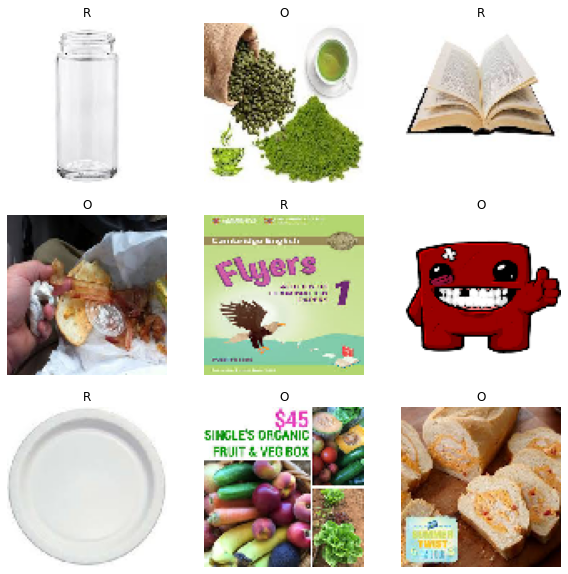

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(train_ds[0][0][i].astype('uint8'))
  index = np.argmax(train_ds[0][1][i])
  plt.title(class_names[index])
  plt.axis("off")

### Define model

In [ ]:
import tensorflow_hub as hub

num_classes = train_ds.num_classes

# Name model with used architecture
model_name = CNN_FEATURE_VECTOR.split('/')[5]
model_dir = pathlib.Path(f'/content/models/{model_name}')
model_dir.mkdir(exist_ok=True, parents=True)

model = tf.keras.Sequential()

model.add(tf.keras.layers.Rescaling(1./255))
model.add(hub.KerasLayer(CNN_FEATURE_VECTOR, trainable=False))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(96, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(48, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(num_classes, activation=DENSE_LAYER_ACTIVATION))

In [ ]:
from tensorflow.keras import optimizers

sgd = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=sgd,
              loss=OBJECTIVE_FUNCTION,
              metrics=LOSS_METRICS)

### Train model

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=EARLY_STOP_PATIENCE
)

base_model_path = 'model.h5'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    base_model_path,
    save_best_only=True
)

In [ ]:
model.fit(
    train_ds,
    steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping, model_checkpoint]
)
# Also add epochs that model has been trained on
import sys
original_stdout = sys.stdout # Save a reference to the original standard output
with open(f'{model_dir}/{model_name}.txt', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    model.summary()
    sys.stdout = original_stdout # Reset the standard output to its original value

Epoch 1/50
10/10 [==============================] - 268s 27s/step - loss: 0.5577 - accuracy: 0.7680 - val_loss: 0.2203 - val_accuracy: 0.9267
Epoch 2/50
10/10 [==============================] - 40s 4s/step - loss: 0.2567 - accuracy: 0.9020 - val_loss: 0.1692 - val_accuracy: 0.9413
Epoch 3/50
10/10 [==============================] - 41s 4s/step - loss: 0.3014 - accuracy: 0.9070 - val_loss: 0.1689 - val_accuracy: 0.9389
Epoch 4/50
10/10 [==============================] - 39s 4s/step - loss: 0.2640 - accuracy: 0.9024 - val_loss: 0.1696 - val_accuracy: 0.9364
Epoch 5/50
10/10 [==============================] - 40s 4s/step - loss: 0.2006 - accuracy: 0.9330 - val_loss: 0.1593 - val_accuracy: 0.9424
Epoch 6/50
10/10 [==============================] - 40s 4s/step - loss: 0.1683 - accuracy: 0.9400 - val_loss: 0.1488 - val_accuracy: 0.9457
Epoch 7/50
10/10 [==============================] - 44s 5s/step - loss: 0.2169 - accuracy: 0.9240 - val_loss: 0.1356 - val_accuracy: 0.9539
Epoch 8/50
10/10 [

### Convert to tflite

In [ ]:
def representative_data_gen():
  a = []
  limit = 3
  counter = 0
  for batch in train_ds:
    counter += 1
    if counter == 3:
      break
    input_tensor = batch[0]
    for i in range(input_tensor.shape[0]):
      a.append(input_tensor[i])
  a = np.asarray(a)
  ds = tf.data.Dataset.from_tensor_slices(a).batch(1)
  for i in ds.take(100):
    yield [i]

def write_to_file(text):
  with open(f'{model_dir}/{model_name}.txt', 'a') as f:
    f.write(text + '\n')

def no_quantization(converter):
  write_to_file('quantization: none')
  return converter.convert()

# Smaller model with quantized weights, but other variable data still in float format
# NOTE: Hybrid models are not supported in TFlite Micro
def dynamic_quantization(converter):
  write_to_file('quantization: dynamic')
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  return converter.convert()

# All weights and variable data quantized
# Not compatible with devices that perform only integer-based operations 
def float_quantization(converter):
  write_to_file('quantization: float')
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  converter.representative_dataset = representative_data_gen
  return converter.convert()

# All weights and variable data quantized
# Internal quantization is the same as with float, but inuput and output tensors format is changed to uint8
def int_quantization(converter):
  write_to_file('quantization: int')
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  converter.representative_dataset = representative_data_gen
  # Ensure that if any ops can't be quantized, the converter throws an error
  converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
  # Set the input and output tensors to uint8 (APIs added in r2.3)
  converter.inference_input_type = tf.uint8
  converter.inference_output_type = tf.uint8
  return converter.convert()

converter = tf.lite.TFLiteConverter.from_keras_model(model)
if QUANTIZATION == 'none':
  tflite_model = no_quantization(converter)
elif QUANTIZATION == 'dynamic':
  tflite_model = dynamic_quantization(converter)
elif QUANTIZATION == 'float':
  tflite_model = float_quantization(converter)
elif QUANTIZATION == 'int':
  tflite_model = int_quantization(converter)

/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


### Check model accuracy

In [ ]:
loss, acc = model.evaluate(val_ds)
write_to_file(f'loss={loss}, accuracy={acc}')

46/46 [==============================] - 33s 710ms/step - loss: 0.0758 - accuracy: 0.9776


### Save model

In [ ]:
import pathlib

model_save_name = f'{model_name}.tflite'

tflite_model_file = model_dir/model_save_name
tflite_model_file.write_bytes(tflite_model)

with open(f'{model_dir}/labels.txt', 'a') as f:
    for class_name in class_names:
      f.write(class_name + '\n')

### Test model

[0.4453125 0.5546875]
1
R


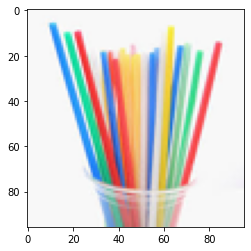

In [ ]:
# # Initialize the interpreter
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

# Load image
import urllib.request
import numpy as np
from PIL import Image

# image = Image.open('/content/gdrive/MyDrive/organic/TEST/O/O_12574.jpg').resize((96,96))
image = Image.open('/content/gdrive/MyDrive/organic/TEST/R/R_10437.jpg').resize((96,96))
# url = "https://grzyby-pk.pl/gat_a/imgduze/amanita_virosa00.jpg"

# urllib.request.urlretrieve(
#     url,
#    "gfg.jpg")
# image = Image.open('gfg.jpg').resize((96,96))
image = np.asarray(image)
image = image.reshape((96, 96, 3))

test_image = np.expand_dims(image, axis=0).astype(input_details["dtype"])
interpreter.set_tensor(input_details['index'], test_image)
interpreter.invoke()

output = interpreter.get_tensor(output_details['index'])[0]
print(output)
print(output.argmax())
print(class_names[output.argmax()])

import matplotlib.pylab as plt

plt.imshow(image)

im = Image.fromarray(image)
im.save('mas.jpg')

#### DEBUG: Test other model

In [ ]:
# # # Initialize the interpreter
# model_path = "/content/mobilenet_v2_100_96 (1).tflite"
# width = 96
# height = 96
# interpreter = tf.lite.Interpreter(model_path=str(model_path))
# interpreter.allocate_tensors()

# input_details = interpreter.get_input_details()[0]
# output_details = interpreter.get_output_details()[0]

# # Load image
# import urllib.request
# import numpy as np
# from PIL import Image

# url = "https://img.freepik.com/free-psd/wine-bottle-label-mockup-design_23-2149458593.jpg?w=2000"

# urllib.request.urlretrieve(
#     url,
#    "gfg.jpg")
# image = Image.open('gfg.jpg').resize((96,96))
# image = np.asarray(image)
# image = image.reshape((96, 96, 3))

# test_image = np.expand_dims(image, axis=0).astype(input_details["dtype"])
# interpreter.set_tensor(input_details['index'], test_image)
# interpreter.invoke()

# output = interpreter.get_tensor(output_details['index'])[0]
# print(output)
# print(output.argmax())

# import matplotlib.pylab as plt

# plt.imshow(image)